In [ ]:
!pip install xlsxwriter
import time
import xlrd
import xlsxwriter
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from random import randint
from numpy import mean
from numpy import absolute
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score




In [ ]:
row = 0
column = 0

In [ ]:
size_pop = 10
size_gen = 10
cross_rate = 0.8
mutation_rate = 0.2
size_cross = cross_rate*size_pop
N = int(size_pop-size_cross)

In [ ]:
def read_data():
    with open('ImmuneSystem.csv') as csv_file:

        csv_reader = csv.reader(csv_file, delimiter=',')
        label = []
        data = []
        row = 0
        line_num = 0
        for row_data in csv_reader:

            if line_num == 0:
                column = len(row_data) - 1
                size_pop = column//5

            else:
                label.append(row_data[0])
                data.append(row_data[1:])

            line_num += 1

    for i in range(len(label)):
        label[i] = label[i].replace('BL', '4')
        t = label[i].split('_')
        label[i] = t[1]

    data = np.array(data)
    label = np.array(label)

    return data, label

In [ ]:
def individual(lenght):
    chromosome = []
    for i in range(lenght):
        chromosome.append(np.random.choice([0, 1], p=[0.8, 0.2]))

    #chromosome=[random.randint(0,1) for i in range(lenght)]
    # print(chromosome)
    return chromosome

In [ ]:
def fit_data(bv, samples):
    fit_samples = []

    for i in range(len(bv)):
        if bv[i] == 1:
            fit_samples.append(samples[:, i])

    return fit_samples

In [ ]:
def compute_fitness(fit_samples, label):

    fit_samples = np.array(fit_samples)
    fit_samples = np.transpose(fit_samples)

    #X_train, X_test, y_train, y_test = train_test_split(fit_samples, label, test_size=0.33)
    model = ElasticNet(alpha=1.0, l1_ratio=0.01)
    cv = RepeatedKFold(n_splits=10, n_repeats=20, random_state=1)
    scores = cross_val_score(model, fit_samples, label,
                             scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    scores = absolute(scores)
    f = mean(scores)

    # enet.fit(X_train,y_train)
    # y_pred=enet.predict(X_test)
    #f=accuracy_score(y_test, y_pred, normalize=False)

    return f

In [ ]:
def first_population(samples, label):
    population_list = []

    for i in range(size_pop):
        binary_vector = individual(len(samples[0]))
        # print(binary_vector)

        # print(samples)

        fit_samples = fit_data(binary_vector, samples)

        f = compute_fitness(fit_samples, label)
        # print(f)
        # print(f"{f}/{binary_vector}")
        population_list.append((binary_vector, f))

    return population_list


In [ ]:
def cross(population, samples, label):
    new_population = []
    for _ in range(int(size_cross//2)):
        v1 = randint(0, len(population)-1)
        v2 = randint(0, len(population)-1)

        mid = randint(1, len(population[v1][0])-2)
        child1 = population[v1][0][:mid]+population[v2][0][mid:]
        child2 = population[v2][0][:mid]+population[v1][0][mid:]

        # print(f'v1={population[v1][0]}\nv2={population[v2][0]}\nmid={mid}')
        # print(f'child1={child1}\nlen={len(population[v1][0])==len(child1)}')
        #print(f'check sides\nv1={population[v1][0][:mid]==child1[:mid]}\nv2={population[v2][0][mid:]==child1[mid:]}')

        # print(f'child2={child2}\nlen={len(population[v1][0])==len(child2)}')
        #print(f'check sides\nv1={population[v2][0][:mid]==child2[:mid]}\nv2={population[v1][0][mid:]==child2[mid:]}')

        fit_samples = fit_data(child1, samples)

        fitness = compute_fitness(fit_samples, label)

        new_population.append((child1, fitness))

        # child2

        fit_samples = fit_data(child2, samples)

        fitness = compute_fitness(fit_samples, label)

        new_population.append((child2, fitness))

    #new_population.sort(key=lambda tup:tup[1])

    return new_population


In [ ]:
def mutant(population, samples, labels, rate=0.5):
    new_population = []
    for p in population:
        mut = random.uniform(0, 1)
        if mut < mutation_rate:
            chromosom = []
            for ch in p[0]:
                if random.uniform(0, 1) > rate:
                    if ch == 1:
                        chromosom.append(0)
                    else:
                        chromosom.append(1)
                else:
                    chromosom.append(ch)

            fit_samples = fit_data(chromosom, samples)
            fitness = compute_fitness(fit_samples, labels)
            if fitness < p[1]:
                new_population.append((chromosom, fitness))
            else:
                new_population.append(p)
        else:
            new_population.append(p)
    return new_population

In [ ]:
def read_feature():
    features = []
    with open("ImmuneSystem.csv", "r") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        features = next(csv_reader)
        features.pop(0)
        # print(features[0])
    return features


In [ ]:
def check_feature(individual_feature):
    selected_features = []
    wb = xlrd.open_workbook("ImmuneSystem.xlsx")
    sheet = wb.sheet_by_index(0)
    for i in range(sheet.nrows):
        selected_features.append(sheet.cell_value(i, 0))

    detected_features = list(filter(lambda x: x in selected_features, individual_feature))
    not_detected_features = list(filter(lambda x: x not in individual_feature, selected_features))
    extera_features = list(filter(lambda x: x not in selected_features, individual_feature))

    return {"detected": detected_features, "not_detected": not_detected_features, "extera": extera_features}

In [ ]:
def write_check(features, name):
    workbook = xlsxwriter.Workbook(f'{name}.xlsx')
    worksheet = workbook.add_worksheet()
    row = 0
    col = 0

    for key in features:
        worksheet.write(row,col, str(key))
        row+=1
        for item in features[key]:
            worksheet.write(row, col, item)
            row+=1
        row=0
        col+=1

    workbook.close()

In [ ]:
def main():
    features = read_feature()
    f_new = open("best.csv", "w")
    best_file = csv.writer(f_new)
    best_file.writerow(["generation", "fitness", "features",
                       "number of features", "binary_vector"])

    data, label = read_data()

    population = first_population(data, label)
    # *********************************

    # for i in range(len(population)):
    # print(population[i][1])

    generation_fitness = []
    best_number = 0
    fit_best = 1000

    for g in range(1000):
        population.sort(key=lambda tup: tup[1])
        print(g, population[0][1])
        temp = population[0][1]
        if temp < fit_best:
            fit_best = temp
            best_number = 0
        else:
            best_number += 1
            if best_number > size_pop:
                break

        p = population[0]
        name_gene = []
        for i in range(len(p[0])):
            if p[0][i] == 1:
                name_gene.append(features[i])

        best_file.writerow([g+1, p[1], name_gene, len(name_gene), p[0]])

        generation_fitness.append(p[1])
        # print("generation",generation_fitness,"gstop")

        new_population = []

        new_population = cross(population, data, label)
        #print(f"{g}/cross/{[i[1] for i in new_population]}")
        for i in range(N):
            new_population.append(population[i])

        population = mutant(new_population, data, label)
        #print(f"{g}/mutation/{[i[1] for i in population]}")

    # print(best_features)
    plt.plot(list(range(1, len(generation_fitness)+1)), generation_fitness)
    plt.savefig("data.png")
    plt.show()

    f_new.close()
    

    return population

0 0.9856974108889651
1 0.9717504509570223
2 0.9717504509570223
3 0.9687303348489578
4 0.9678090430400662
5 0.9645878804873894
6 0.9645878804873894
7 0.9645878804873894
8 0.9639737317792296
9 0.9606757290958159
10 0.9606757290958159
11 0.9588942667703461
12 0.9588942667703461
13 0.9588942667703461
14 0.9588942667703461
15 0.9580465783224438
16 0.9580465783224438
17 0.9557169376900131
18 0.9557169376900131
19 0.9557169376900131
20 0.9557169376900131
21 0.9551891405397626
22 0.9551891405397626
23 0.9551891405397626
24 0.9551891405397626
25 0.9551891405397626
26 0.9551891405397626
27 0.9551891405397626
28 0.9545593478354784
29 0.9545593478354784
30 0.9533833284694023
31 0.9533833284694023
32 0.9527818092640519
33 0.951779715359807
34 0.951779715359807
35 0.951779715359807
36 0.951779715359807
37 0.9515324463334528
38 0.9515324463334528
39 0.9477159787395874
40 0.9477159787395874
41 0.9477159787395874
42 0.9477159787395874
43 0.9477159787395874
44 0.9477159787395874
45 0.9477159787395874
46

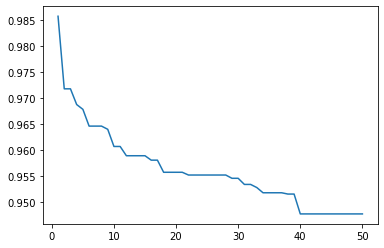

--- 1210.7158856391907 Seconds ---


In [ ]:
start_time = time.time()
main()
print("--- %s Seconds ---" % (time.time() - start_time))

In [ ]:
with open('best.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    for row in csv_reader:
      best_feature = literal_eval(row[2])    
      check = check_feature(best_feature)
      print(f'generation: {row[0]} fitness: {row[1]} detected: {len(check["detected"])} undetected: {len(check["not_detected"])} extera: {len(check["extera"])}')
      write_check(check, row[0])

generation: 1 fitness: 0.9856974108889651 detected: 1 undetected: 79 extera: 114
generation: 2 fitness: 0.9717504509570223 detected: 3 undetected: 76 extera: 264
generation: 3 fitness: 0.9717504509570223 detected: 3 undetected: 76 extera: 264
generation: 4 fitness: 0.9687303348489578 detected: 2 undetected: 78 extera: 274
generation: 5 fitness: 0.9678090430400662 detected: 2 undetected: 77 extera: 274
generation: 6 fitness: 0.9645878804873894 detected: 2 undetected: 77 extera: 233
generation: 7 fitness: 0.9645878804873894 detected: 2 undetected: 77 extera: 233
generation: 8 fitness: 0.9645878804873894 detected: 2 undetected: 77 extera: 233
generation: 9 fitness: 0.9639737317792296 detected: 2 undetected: 78 extera: 230
generation: 10 fitness: 0.9606757290958159 detected: 2 undetected: 77 extera: 271
generation: 11 fitness: 0.9606757290958159 detected: 2 undetected: 77 extera: 271
generation: 12 fitness: 0.9588942667703461 detected: 2 undetected: 78 extera: 253
generation: 13 fitness: 0